In [ ]:
#Import dataset image from API Kaagle
!pip install -q kaggle

In [5]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"daniel102512","key":"e03d59d8227cb743c8eb1d1e5b720f55"}'}

In [6]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

#Modelos con el primer dataset

---



##Modelo VGG16

In [66]:
import numpy as np
import pandas as pd
import tensorflow as tf

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import os
import random
import keras

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator

from keras.layers import Dense, Flatten, AveragePooling2D, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, recall_score, accuracy_score, precision_score, f1_score
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet121
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet_v3 import MobileNetV3, MobileNetV3Small, MobileNetV3Large
from keras.models import Model

In [7]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 98% 731M/745M [00:04<00:00, 177MB/s]
100% 745M/745M [00:04<00:00, 161MB/s]


In [8]:
!unzip covid19-radiography-database.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6710.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6711.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6712.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6713.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6714.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6715.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6716.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6717.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6718.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6719.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-672.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6720.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6721.png  
  inflating: COVID-19_Radiography_Dataset/Normal/Normal-6722.pn

In [67]:
c = 'COVID-19_Radiography_Dataset/COVID'
p = 'COVID-19_Radiography_Dataset/Viral Pneumonia'

In [68]:
random.seed(42)
filenames = random.sample(os.listdir(c), 1500) + os.listdir(p)

In [69]:
categories = []
for filename in filenames:
    category = filename.split('-')[0]
    if category == 'COVID':
        categories.append(str(1))
    elif category == 'Viral Pneumonia':
        categories.append(str(0))

In [70]:
for i in range(len(filenames)):
    if 'COVID' in filenames[i]:
        filenames[i] = os.path.join(c, filenames[i])
    elif 'Viral Pneumonia' in filenames[i]:
        filenames[i] = os.path.join(p, filenames[i])
    
df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [71]:
df.head()

filename category
0  COVID-19_Radiography_Dataset/COVID/COVID-1952.png        1
1   COVID-19_Radiography_Dataset/COVID/COVID-358.png        1
2  COVID-19_Radiography_Dataset/COVID/COVID-1781.png        1
3  COVID-19_Radiography_Dataset/COVID/COVID-1992.png        1
4   COVID-19_Radiography_Dataset/COVID/COVID-845.png        1

In [72]:
df['category'].value_counts()

1    1500
0    1345
Name: category, dtype: int64

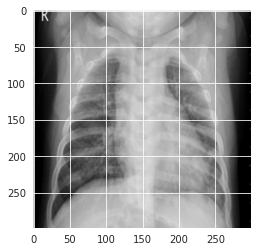

COVID-19_Radiography_Dataset/Viral Pneumonia/Viral Pneumonia-1320.png


In [73]:
sample = random.choice(df['filename'])
image = load_img(sample)
plt.imshow(image)
plt.show()
print(sample)

In [74]:
#dividimos los datos que se van a usar como train, test y validacion en 80-10-10
train_data, test_valid_data = train_test_split(df, test_size=0.2, random_state = 42, shuffle=True, stratify=df['category'])
train_data = train_data.reset_index(drop=True)
test_valid_data = test_valid_data.reset_index(drop=True)

In [75]:
test_data, valid_data = train_test_split(test_valid_data, test_size=0.5, random_state = 42,
                                         shuffle=True, stratify=test_valid_data['category'])
test_data = test_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)

In [76]:
#se hace data augmentation solamente en las imagenes de entrenamiento para tener diferentes alternativas realistas de las imagenes
train_data_gen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)
train_generator = train_data_gen.flow_from_dataframe(
    train_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 2276 validated image filenames belonging to 2 classes.


In [77]:
valid_data_gen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_data_gen.flow_from_dataframe(
    valid_data, 
    x_col='filename',
    y_col='category',
    target_size=(224,224),
    class_mode='categorical',
    batch_size=15
)

Found 285 validated image filenames belonging to 2 classes.


In [93]:
baseModel = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

In [94]:
opt = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [95]:
epochs = 3
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs)

Epoch 1/3
152/152 [==============================] - 46s 283ms/step - loss: 0.3811 - accuracy: 0.8431 - val_loss: 0.1927 - val_accuracy: 0.9368
Epoch 2/3
152/152 [==============================] - 41s 270ms/step - loss: 0.1494 - accuracy: 0.9613 - val_loss: 0.0909 - val_accuracy: 0.9719
Epoch 3/3
152/152 [==============================] - 41s 266ms/step - loss: 0.1075 - accuracy: 0.9741 - val_loss: 0.0639 - val_accuracy: 0.9825


In [96]:
model.save('ModeloDS1VGG16.h5')

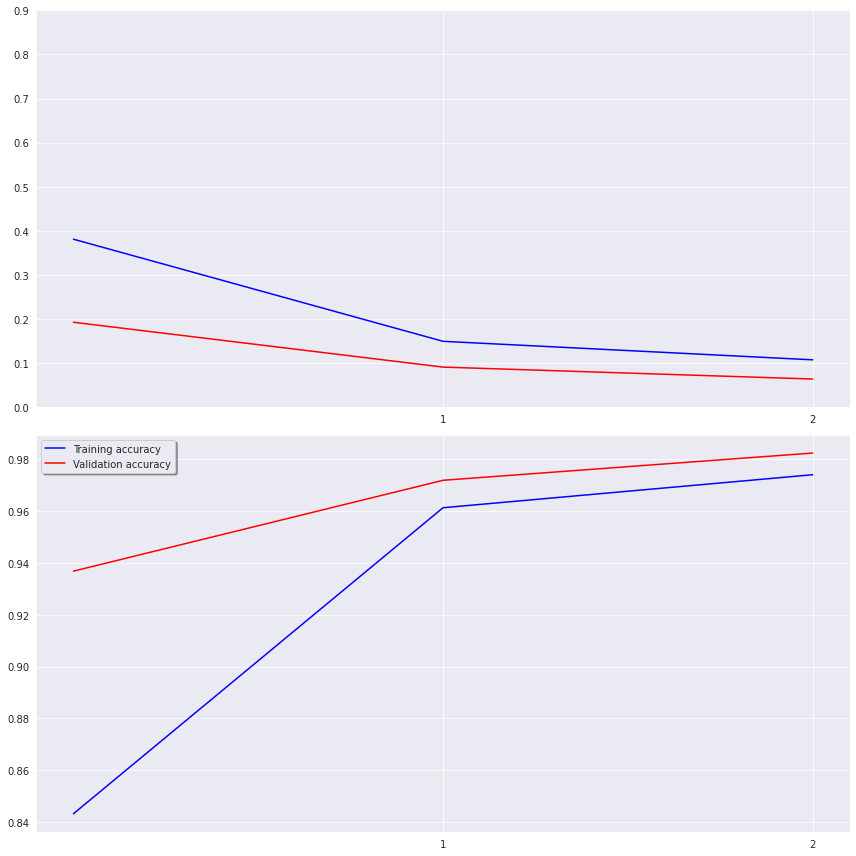

In [97]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [98]:
model = tf.keras.models.load_model('/content/ModeloDS1VGG16.h5')

True value is : COVID
Prediction is:
COVID


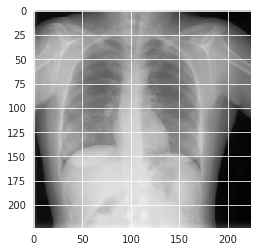

In [102]:
sample = random.choice(test_data['filename'])


category = sample.split('/')[1]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Viral Pneumonia")
elif result == 1:
    print("COVID")
    
plt.imshow(image)

##Modelo con InceptionV3

In [22]:
baseModel = InceptionV3(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                           

In [27]:
opt = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
epochs = 3
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs)

Epoch 1/3
152/152 [==============================] - 54s 260ms/step - loss: 0.1437 - accuracy: 0.9438 - val_loss: 0.0290 - val_accuracy: 0.9860
Epoch 2/3
152/152 [==============================] - 38s 249ms/step - loss: 0.0844 - accuracy: 0.9697 - val_loss: 0.0491 - val_accuracy: 0.9825
Epoch 3/3
152/152 [==============================] - 38s 248ms/step - loss: 0.0617 - accuracy: 0.9789 - val_loss: 0.0486 - val_accuracy: 0.9860


In [32]:
model.save('ModeloDS1INCEPTIONV3.h5')

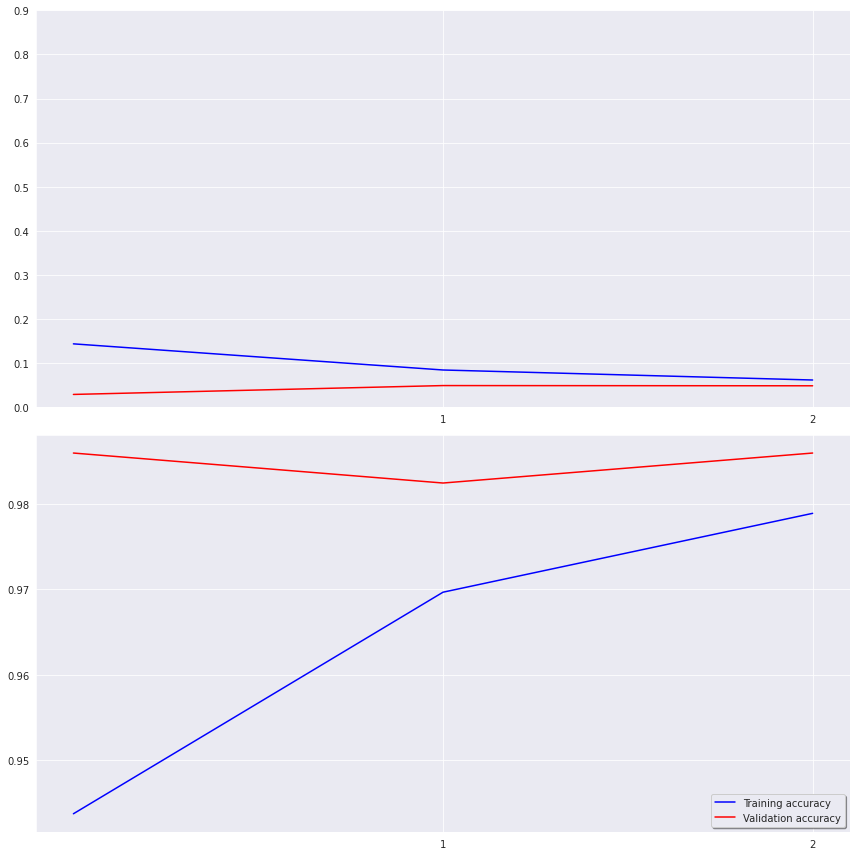

In [30]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [104]:
model = tf.keras.models.load_model('/content/ModeloDS1INCEPTIONV3.h5')

True value is : COVID
Prediction is:
COVID


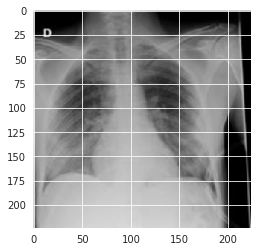

In [117]:
sample = random.choice(test_data['filename'])


category = sample.split('/')[1]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Viral Pneumonia")
elif result == 1:
    print("COVID")
    
plt.imshow(image)


##Modelo con MobileNetV3Large

In [35]:
baseModel = MobileNetV3Large(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

12697600/12683000 [==============================] - 0s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 224, 224, 3)  0           ['input_4[0][0]']                
                                                                                                  
 Conv (Conv2D)                  (None, 112, 112, 16  432         ['rescaling_1[0][0]']            
                                )                                                                 
                           

In [36]:
opt = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
epochs = 3
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs)

Epoch 1/3
152/152 [==============================] - 44s 259ms/step - loss: 0.6150 - accuracy: 0.6648 - val_loss: 0.4703 - val_accuracy: 0.8316
Epoch 2/3
152/152 [==============================] - 33s 215ms/step - loss: 0.5093 - accuracy: 0.7685 - val_loss: 0.3836 - val_accuracy: 0.8456
Epoch 3/3
152/152 [==============================] - 33s 218ms/step - loss: 0.4700 - accuracy: 0.7953 - val_loss: 0.3397 - val_accuracy: 0.8561


In [38]:
model.save('ModeloDS1MobileNetV3Large.h5')

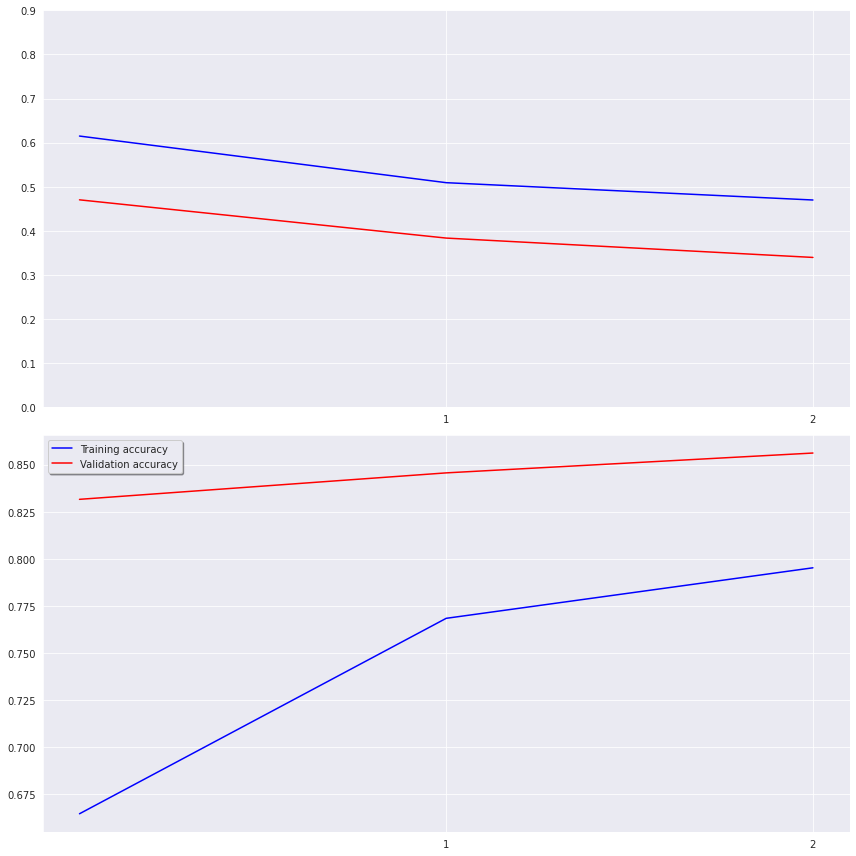

In [39]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [118]:
model = tf.keras.models.load_model('/content/ModeloDS1MobileNetV3Large.h5')

True value is : Viral Pneumonia
Prediction is:
Viral Pneumonia


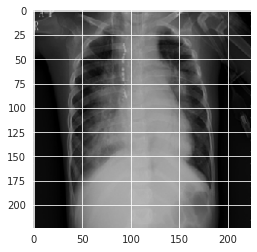

In [125]:
sample = random.choice(test_data['filename'])


category = sample.split('/')[1]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Viral Pneumonia")
elif result == 1:
    print("COVID")
    
plt.imshow(image)

##Modelo con DenseNet121

In [47]:
baseModel = DenseNet121(input_shape=(224,224,3), weights='imagenet', include_top=False)

for layer in baseModel.layers:
    layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)
model.summary()

29097984/29084464 [==============================] - 0s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_5[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                           

In [48]:
opt = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [49]:
epochs = 3
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs)

Epoch 1/3
152/152 [==============================] - 51s 278ms/step - loss: 0.1199 - accuracy: 0.9530 - val_loss: 0.0253 - val_accuracy: 0.9895
Epoch 2/3
152/152 [==============================] - 39s 253ms/step - loss: 0.0504 - accuracy: 0.9829 - val_loss: 0.0258 - val_accuracy: 0.9930
Epoch 3/3
152/152 [==============================] - 37s 246ms/step - loss: 0.0424 - accuracy: 0.9851 - val_loss: 0.0229 - val_accuracy: 0.9930


In [50]:
model.save('ModeloDS1DenseNet121.h5')

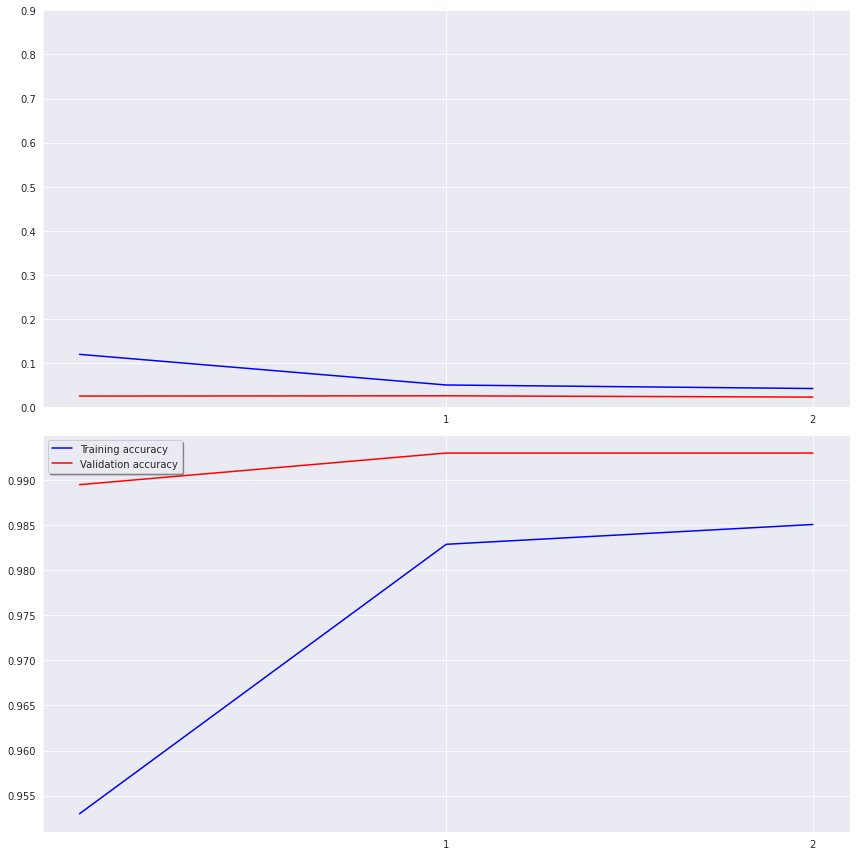

In [51]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [128]:
model = tf.keras.models.load_model('/content/ModeloDS1DenseNet121.h5')

True value is : COVID
Prediction is:
COVID


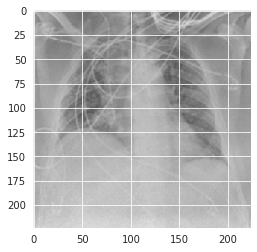

In [130]:
sample = random.choice(test_data['filename'])


category = sample.split('/')[1]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Viral Pneumonia")
elif result == 1:
    print("COVID")
    
plt.imshow(image)

##Modelo con ChexNet

In [ ]:
!gdown https://drive.google.com/file/d/1iEJIACWv_HGcdyw_U_NTl5uKBkGFznjQ #descargar los pesos de CheXNet

In [79]:
chexnet_weights_path = "/content/brucechou1983_CheXNet_Keras_0.3.0_weights.h5"

In [80]:
baseModel = DenseNet121(input_shape=(224,224,3), weights=None, include_top=False)
predictions = tf.keras.layers.Dense(14, activation='sigmoid', name='predictions')(baseModel.output)
baseModel = tf.keras.Model(inputs=baseModel.input, outputs=predictions)

baseModel.load_weights(chexnet_weights_path) #Cargamos los pesos de la ChexNet

for layer in baseModel.layers: #Cargamos la DenseNet121 con los pesos de ChexNet
    layer.trainable = False    #y congelamos las capas

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten()(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(2, activation='softmax')(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [81]:
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d_6 (ZeroPadding2  (None, 230, 230, 3)  0          ['input_8[0][0]']                
 D)                                                                                               
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d_6[0][0]']       
                                )                                                           

In [82]:
opt = tf.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [84]:
epochs = 3
history = model.fit_generator(train_generator,
                              validation_data=valid_generator, verbose=1, epochs=epochs)

Epoch 1/3
152/152 [==============================] - 56s 301ms/step - loss: 0.6920 - accuracy: 0.5228 - val_loss: 0.6909 - val_accuracy: 0.5263
Epoch 2/3
152/152 [==============================] - 39s 256ms/step - loss: 0.6905 - accuracy: 0.5272 - val_loss: 0.6892 - val_accuracy: 0.5263
Epoch 3/3
152/152 [==============================] - 39s 256ms/step - loss: 0.6893 - accuracy: 0.5272 - val_loss: 0.6877 - val_accuracy: 0.5263


In [85]:
model.save('ModeloDS1ChexNet.h5')

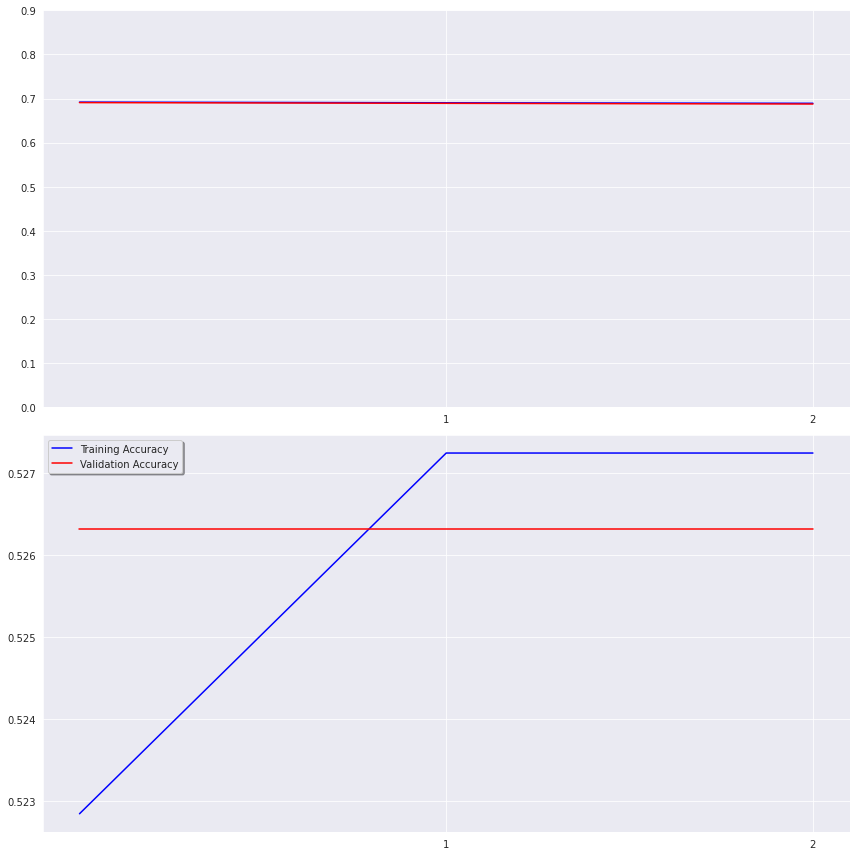

In [86]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training Accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation Accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [131]:
model = tf.keras.models.load_model('/content/ModeloDS1ChexNet.h5')

True value is : Viral Pneumonia
Prediction is:
COVID


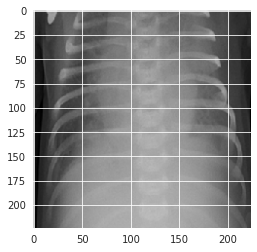

In [133]:
sample = random.choice(test_data['filename'])


category = sample.split('/')[1]
true = ''
if category == 'COVID':
    true = 'COVID'
elif category == 'Viral Pneumonia':
    true = 'Viral Pneumonia'

print(f'True value is : {true}')
    
image = load_img(sample, target_size=(224, 224))
img = img_to_array(image)
img = img.reshape((1, 224, 224, 3))

result = model.predict(img)
result = np.argmax(result, axis=-1)
print('Prediction is:')
if result == 0:
    print("Viral Pneumonia")
elif result == 1:
    print("COVID")
    
plt.imshow(image)

#Modelos con el segundo dataset

---



In [ ]:
!kaggle datasets download -d amanullahasraf/covid19-pneumonia-normal-chest-xray-pa-dataset

 99% 1.90G/1.91G [00:45<00:00, 63.4MB/s]
100% 1.91G/1.91G [00:45<00:00, 44.7MB/s]


In [ ]:
!unzip covid19-pneumonia-normal-chest-xray-pa-dataset.zip

Se truncaron las últimas líneas 5000 del resultado de transmisión.
  inflating: covid/COVID19(303).jpg  
  inflating: covid/COVID19(304).jpg  
  inflating: covid/COVID19(305).jpg  
  inflating: covid/COVID19(306).jpg  
  inflating: covid/COVID19(307).jpg  
  inflating: covid/COVID19(308).jpg  
  inflating: covid/COVID19(309).jpg  
  inflating: covid/COVID19(31).jpg   
  inflating: covid/COVID19(310).jpg  
  inflating: covid/COVID19(311).jpg  
  inflating: covid/COVID19(312).jpg  
  inflating: covid/COVID19(313).jpg  
  inflating: covid/COVID19(314).jpg  
  inflating: covid/COVID19(315).jpg  
  inflating: covid/COVID19(316).jpg  
  inflating: covid/COVID19(317).jpg  
  inflating: covid/COVID19(318).jpg  
  inflating: covid/COVID19(319).jpg  
  inflating: covid/COVID19(32).jpg   
  inflating: covid/COVID19(320).jpg  
  inflating: covid/COVID19(321).jpg  
  inflating: covid/COVID19(322).jpg  
  inflating: covid/COVID19(323).jpg  
  inflating: covid/COVID19(324).jpg  
  inflating: covid/CO

In [ ]:
from __future__ import print_function, division
import os
from os import walk
import sys
import torch
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import tqdm
import re

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")
    
all_best_accs = []

PATH = '/content/covid19-pneumonia-normal-chest-xray-pa-dataset' 

Using CUDA


In [ ]:
available_models = ["resnet","alexnet","vgg","squeezenet","densenet","inception"]

def set_parameter_requires_grad(model, feature_extracting): #function to freezing parameters in our model
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False
            
def initialize_model(model_name, num_classes = 2, feature_extract = True, use_pretrained=True): # num_classes=3 
                                                                                                #since we have 3 classes
    
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    
    model_name = model_name.lower() 
    model_name.replace(" ", "") # removing spaces in string
    model_name = re.sub(r'[0-9]',"",model_name) # removing numbers in string
    
    
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_name = "Resnet18"
        model_ft = models.resnet18(pretrained=use_pretrained) # using pretrained weights
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)   # setting number of outputs to 3 (initially most models have number of 
                                                         #  outputs as 1000 since they are trained on imagenet)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_name = "Alexnet"
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG16_bn
        """
        model_name = "VGG16 with batch normalization"
        model_ft = models.vgg16_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_name = "Squeezenet"
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_name = "Densenet"
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has two outputs normal output and auxiliary output
        """
        model_name = "Inception v3"
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()
    model_ft = model_ft.to(device)
    return model_ft, input_size

In [ ]:
# available_models = ["resnet","alexnet","vgg","squeezenet","densenet","inception"]
model_name = "inception"
model, size = initialize_model(model_name)
print("model =",model_name,"\nsize of image = "+ str(size)) # optimal size of the image to be given input

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

model = inception 
size of image = 299


In [ ]:
data_dir = PATH 
batch_size = 32
valid_size = 0.1 # define partition of validation size in train size

# Defining transforms for the training data and testing data
data_transforms = transforms.Compose([transforms.RandomAffine(degrees = [0,9], shear = [0., 0.066, 0.133, 0.2]),
                                       transforms.Resize((size,size)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor()])


# obtain training indices that will be used for validation
data = datasets.ImageFolder(data_dir , transform= data_transforms)
dataset_sizes = {"train" : (len(data)*9)//10, "val" : len(data)//10}
num_train = len(data)

indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))

train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=valid_sampler)
data_loader = {"train" : train_loader, "val" : val_loader}
phases = ["train", "val"]
class_names = data.classes

print("The Classes are : ",end = "")
print(*class_names,sep = ", ")

The Classes are : covid, pneumonia


torch.Size([3, 299, 299])


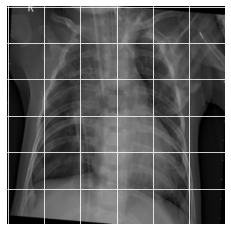

In [ ]:
def imshow1(image, ax=None, title=None, normalize=True):
    #Imshow for Tensor
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0., 0., 0.])
        std = np.array([1., 1., 1.])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

data_iter = iter(val_loader)

images, labels = next(data_iter)
print(images[0].shape)
imshow1(images[0])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, epochs= 3):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, epochs+1):
        print('Epoch {}/{}'.format(epoch, epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for batch, (inputs, labels) in enumerate(data_loader[phase]):
                print("\r batch {}/{}".format(batch+1, len(data_loader[phase])), end='', flush=True)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    if model_name == "inception" and phase == "train": # Will only run for incepton training
                        outputs,aux = model(inputs)
                    else:
                        outputs = model(inputs)
                    
                    _, preds = torch.max(outputs, 1)
                    
                    if model_name == "inception" and phase == "train": # Will only run for incepton training
                        loss = criterion(outputs,labels) + 0.4*criterion(aux,labels)
                    else:
                        loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('\n{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    all_best_accs.append(best_acc)
    return model

In [ ]:
model = {x:[] for x in available_models}

begin_tol = time.time()

for model_name in available_models:
    
    # ----------------> Initialization part
    model[model_name], size = initialize_model(model_name)
    
    
    # ----------------> Data loader part
    data_dir = PATH
    batch_size = 32
    valid_size = 0.1 # define partition of validation size in train size

    # TODO: Define transforms for the training data and testing data
    train_transforms = transforms.Compose([transforms.RandomAffine(degrees = [0,9], shear = [0., 0.066, 0.133, 0.2]),
                                           transforms.Resize((size,size)),
                                           transforms.RandomHorizontalFlip(),
                                           transforms.ToTensor()])


    # obtain training indices that will be used for validation
    data = datasets.ImageFolder(data_dir , transform=train_transforms)
    dataset_sizes = {"train" : (len(data)*9)//10, "val" : len(data)//10}
    num_train = len(data)

    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))

    train_idx, valid_idx = indices[split:], indices[:split]

    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=train_sampler)
    val_loader = torch.utils.data.DataLoader(data, batch_size=batch_size,sampler=valid_sampler)
    data_loader = {"train" : train_loader, "val" : val_loader}
    modes = ["train", "val"]
    class_names = data.classes    
    
    # ----------------> Training part    
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model[model_name].parameters(), lr = 0.01, momentum = 0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)
    
    print("\n"+"\033[1m" + model_name.upper() + "\033[0m")
    
    train_model(model[model_name], criterion, optimizer, exp_lr_scheduler, epochs = 3)
    torch.save(model[model_name].state_dict(), model_name+'_covid_xray.pt')

    
 # We get the total time for training of all the models    
tol_time = time.time()-begin_tol 
print('Total training completed in {:.0f}m {:.0f}s'.format(tol_time // 60, tol_time % 60))

# Finding the best model on the validation set
overall_best_acc = max(all_best_accs)
best_model_name = available_models[all_best_accs.index(overall_best_acc)]
print("best model is "+best_model_name.upper()+" with accuracy of "+str(overall_best_acc.item()*100)[:6]+" %")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]


RESNET
Epoch 1/3
----------
 batch 130/130
train Loss: 0.2634 Acc: 0.8973
 batch 15/15
val Loss: 0.2332 Acc: 0.9279

Epoch 2/3
----------
 batch 130/130
train Loss: 0.3836 Acc: 0.8976
 batch 15/15
val Loss: 0.1785 Acc: 0.9672

Epoch 3/3
----------
 batch 130/130
train Loss: 0.3724 Acc: 0.9036
 batch 15/15
val Loss: 0.1593 Acc: 0.9629

Training complete in 6m 24s
Best val Acc: 0.967249


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]


ALEXNET
Epoch 1/3
----------
 batch 130/130
train Loss: 0.7887 Acc: 0.8801
 batch 15/15
val Loss: 0.5341 Acc: 0.8755

Epoch 2/3
----------
 batch 130/130
train Loss: 0.8170 Acc: 0.8939
 batch 15/15
val Loss: 0.3704 Acc: 0.9454

Epoch 3/3
----------
 batch 130/130
train Loss: 0.9838 Acc: 0.8942
 batch 15/15
val Loss: 0.3688 Acc: 0.9170

Training complete in 5m 41s
Best val Acc: 0.945415


Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]


VGG
Epoch 1/3
----------
 batch 130/130
train Loss: 0.2445 Acc: 0.9097
 batch 15/15
val Loss: 0.1393 Acc: 0.9651

Epoch 2/3
----------
 batch 130/130
train Loss: 0.2318 Acc: 0.9245
 batch 15/15
val Loss: 0.1713 Acc: 0.9192

Epoch 3/3
----------
 batch 130/130
train Loss: 0.2478 Acc: 0.9203
 batch 15/15
val Loss: 0.1345 Acc: 0.9498

Training complete in 7m 38s
Best val Acc: 0.965066


Downloading: "https://download.pytorch.org/models/squeezenet1_0-b66bff10.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-b66bff10.pth


  0%|          | 0.00/4.78M [00:00<?, ?B/s]


SQUEEZENET
Epoch 1/3
----------
 batch 130/130
train Loss: 0.6417 Acc: 0.6944
 batch 15/15
val Loss: 0.5127 Acc: 0.7227

Epoch 2/3
----------
 batch 130/130
train Loss: 0.3583 Acc: 0.8433
 batch 15/15
val Loss: 0.2327 Acc: 0.9148

Epoch 3/3
----------
 batch 130/130
train Loss: 0.2075 Acc: 0.9223
 batch 15/15
val Loss: 0.1511 Acc: 0.9454

Training complete in 6m 10s
Best val Acc: 0.945415


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]


DENSENET
Epoch 1/3
----------
 batch 130/130
train Loss: 0.2360 Acc: 0.9155
 batch 15/15
val Loss: 0.0929 Acc: 0.9716

Epoch 2/3
----------
 batch 130/130
train Loss: 0.1377 Acc: 0.9511
 batch 15/15
val Loss: 0.0807 Acc: 0.9716

Epoch 3/3
----------
 batch 130/130
train Loss: 0.1645 Acc: 0.9482
 batch 15/15
val Loss: 0.1241 Acc: 0.9694

Training complete in 7m 2s
Best val Acc: 0.971616

INCEPTION
Epoch 1/3
----------
 batch 130/130
train Loss: 0.4179 Acc: 0.8501
 batch 15/15
val Loss: 0.1467 Acc: 0.9563

Epoch 2/3
----------
 batch 130/130
train Loss: 0.3025 Acc: 0.9068
 batch 15/15
val Loss: 0.2472 Acc: 0.9105

Epoch 3/3
----------
 batch 130/130
train Loss: 0.3327 Acc: 0.8930
 batch 15/15
val Loss: 0.1743 Acc: 0.9432

Training complete in 7m 53s
Best val Acc: 0.956332
Total training completed in 41m 40s
best model is DENSENET with accuracy of 97.161 %
